# Import the libraries

In [1]:
from __future__ import division # backward compatibility for python2
import numpy as np
import pandas as pd
import scipy.special
import operator
import random
#library for plotting arrays

import matplotlib.pyplot as plt
# A particularly interesting backend, provided by IPython, is the inline backend. 
# This is available only for the Jupyter Notebook and the Jupyter QtConsole. 
# It can be invoked as follows: %matplotlib inline
# With this backend, the output of plotting commands is displayed inline 
# within frontends like the Jupyter notebook, directly below the code cell that produced it. 
# The resulting plots are inside this notebook, not an external window.
%matplotlib inline

# creating minidatsets for kNN

In [2]:
#splitting the dataset into trainning=80% and test=20%
df = pd.read_csv("mnist.csv")
mn = np.random.rand(len(df)) < 0.2
df_mini_mnist = df[mn]


print(len(df_mini_mnist))

972


In [3]:
#use index=false so pandas dont create a extra index column
df_mini_mnist.to_csv('mini_mnist.csv',index=False)


# set global variables

In [4]:
# datasets to read
# you can change these when trying out other datasets
data_file = "mini_mnist.csv"

class_index = 0 # on inspection of the csv file we see that the class appears in 0th position

# read and split the dataset

In [5]:
def load_dataset(filename, class_idx=class_index, split=0.8):
    dataframe = pd.read_csv(filename)
    #dataframe = dataframe.sample(len(dataframe))
    instances = dataframe.values
    

    print ("Class Index: "+str(class_idx))
    # divide data into label and feature sets.
    X = instances[:,0:784] # you may need to change these depending on which dataset you are use
    Y = instances[:,class_idx] 
    
   
    X_train = [] # features for the train set
    Y_train = [] # class labels for the train set
    X_test = [] # features for the test set
    Y_test = [] # class labels for the test set
    
    # the zip iterator is a neat construct in Python
    # it lets you iterate over 2 arrays / lists structures 
    # importantly it iterates upto the length of the smallest structure of the two 
    # in our case X and Y will be of same length
    for  x, y in zip(X, Y): 
        if random.random() < split: # Return the next random floating point number in the range [0.0, 1.0) and compare
            X_train.append(x)
            Y_train.append(y)
        else:
            X_test.append(x)
            Y_test.append(y)       
    print("train set size: ", len(X_train))       
    print("test set size: ", len(X_test))
    
    return X_train, Y_train, X_test, Y_test

# Define similarity matrics

In [6]:
#Within our class we now need code for each of the components of k-NN.
#First, lets create a method that will measure the distance between two vectors.
def euclidean(instance1, instance2):
        '''
        Calculates euclidean distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):            
            distance += pow((val1 - val2), 2)
        
        distance = pow(distance, 1/2)
             
              
        return 1 / (1+ distance)
    

def manhattan(instance1, instance2):
        '''
        Calculates manhattan distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):
            distance += abs(val1 - val2)      
              
        return 1 / (1+ distance)
    
def dot_product(instance1, instance2):
        '''
        Calculates dot product between two instances 
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        return np.dot(instance1, instance2)

# define evaulation metrics

In [7]:
    #Finally, we can test to see how many of the test instances we got correct
    def accuracy(results):
        correct = 0
        for predict, target in results:
            
            if predict == target:
                correct += 1
        return (correct/float(len(results))) * 100.0

# Bulid the KNN

In [8]:
class kNN:
    """
    Parameters
    X_train, Y_train : list
    these consists of the training set feature values and associated class labels
    k : int
    specify the number of neighbours
    sim : literal
    specify the name of the similarity metric (e.g. manhattan, eucliedean)
    weighted : Boolean
    specify the voting strategy as weighted or not weighted by similarity values
  
    Attributes
    -----------  
    Results : list
      Target and predicted class labels for the test data.    
    """


    def __init__(self, X_train, Y_train, k=3, sim=manhattan, weighted=False):
        self.X_train = X_train
        self.Y_train = Y_train
        
        if k <= len(self.X_train):
            self.k = k # set the k value for neighbourhood size
        else:
            self.k = len(self.X_train) # to ensure the get_neighbours dont crash
    
        self.similarity = sim # specify a sim metric that has been pre-defined e.g. manhattan or euclidean
        
        self.weighted = weighted # boolean to choose between weighted / unweighted majority voting
        
        #store results from testing 
        self.results= []
        
    #With k-NN, we are interested in finding the k number of points with the greatest similarity 
    # to the the query or test instance.
    def get_neighbours(self, test_instance):
        '''
        Locate most similar neighbours 
        X_train will be a containing features (Float) values (i.e. your training data)
        Y_train will be the corresponding class labels for each instance in X_train
        test_instance will be a List of Float values (i.e. a query instance)
        '''
        similarities = [] # collection to store the similarities to be computed

        for train_instance, y in zip(self.X_train, self.Y_train): #for each member of the training set
            sim = self.similarity(test_instance, train_instance) #calculate the similarity to the test instance
            
            similarities.append((y, sim)) #add the actual label of the example and the computed similarity to a collection 
        #print(distances)
        similarities.sort(key = operator.itemgetter(1), reverse = True) #sort the collection by decreasing similarity
        neighbours = [] # holds the k most similar neighbours
        for x in range(self.k): #extract the k top indices of the collection for return
            neighbours.append(similarities[x])

        return neighbours

    # given the neighbours make a prediction
    # the boolean parameter when set to False will use unweighted majority voting; otherwise weighted majority voting
    # weighting can be helpful to break any ties in voting
    def predict(self, neighbours):
        '''
        Summarise a prediction based upon weighted neighbours calculation
        '''
        class_votes = {}
        for x in range(len(neighbours)):
            response = neighbours[x][0]
            if response in class_votes:
                class_votes[response] += (1-self.weighted) + (self.weighted * neighbours[x][1]) #if not weighted simply add 1
                #class_votes[response] += [1, neighbours[x][1]][weighted == True] 
              
            else:
                class_votes[response] = (1-self.weighted) + (self.weighted * neighbours[x][1])
                #class_votes[response] = [1, neighbours[x][1]][weighted == True] 
                
        #print(class_votes)
        sorted_votes = sorted(class_votes, key = lambda k: (class_votes[k], k), reverse = True)
        #print(sorted_votes)
        return sorted_votes[0]
    
    #iterate through all the test data to calculate accuracy
    def test(self, X_test, Y_test):
        self.results = [] # store the predictions returned by kNN

        for test_instance, target_label in zip(X_test, Y_test):
            neighbours = self.get_neighbours(test_instance)
            predict_label = self.predict(neighbours)
            self.results.append([predict_label, target_label])
            #print('> predicted = ', result,', actual = ', test_label)
    

# Load the dataset

In [9]:
#Load the dataset and maintain the features (X) and class labels (Y) separately  
# make sure you understand what the 4 and 0.8 default values are in the call
# you may have to modify these depending on the dataset you work with.
X_train, Y_train, X_test, Y_test = load_dataset(data_file, 0, 0.8)

Class Index: 0
train set size:  780
test set size:  192


# Apply kNN to test Data

In [10]:
#create an instance of kNN 
# pass the training instances with their class labels (i.e. X_train and Y_train)
# we will use the default kNN class settings for parameters i.e. k=3, sim=manhattan, weighted=False

knn = kNN(X_train, Y_train)
knn.test(X_test, Y_test) # now get the predictions on the test set

print("kNN Accuracy on test set is: ", accuracy(knn.results))


kNN Accuracy on test set is:  83.85416666666666


# KNN with multiple values

In [11]:
X_train, Y_train, X_test, Y_test = load_dataset(data_file, 0, 0.8)

Class Index: 0
train set size:  762
test set size:  210


In [14]:
print("Setup the kNN instances ...")
knn_list = []
ks = [1, 10, 20, 30 ,40] # try a few different values for k
is_weighted = [False, True] # try two different forms of voting

# iterate over different voting strategies
for weighted in is_weighted:
    knn_list_element = [] # first set of knns with a specified voting scheme
    #iterate over different k values
    for k in ks:
        #create the different instances of the kNN class
        knn = kNN(X_train, Y_train, k, euclidean, weighted)
        
        knn_list_element.append(knn)
        pass
    
    knn_list.append(knn_list_element)# now append the set of models 
    pass


#lets test the kNNs 
#iterate through each model and accumilate number of correct predictions
knn_results = []
knn_result_element = []

for knn1 in knn_list:
    knn_result_element = []

    for knn2 in knn1:
        knn2.test(X_test, Y_test)
             
        knn_result_element.append(accuracy(knn2.results))
        
        pass
    pass
    knn_results.append(knn_result_element)
    pass
print("Results from trials...", knn_results)


Setup the kNN instances ...
Results from trials... [[91.42857142857143, 87.61904761904762, 84.28571428571429, 82.85714285714286, 82.85714285714286], [91.42857142857143, 89.52380952380953, 84.28571428571429, 83.33333333333334, 84.28571428571429]]


# Plot the results

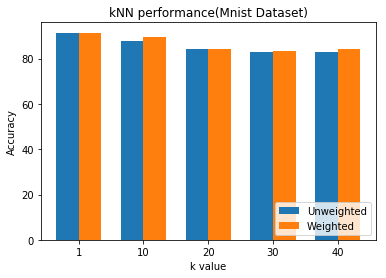

In [13]:
N = len(ks) # this is the number of results we want to plot pn the x-axis
ind = np.arange(N) 

performance1 = knn_results[0]
performance2 = knn_results[1]

width = 0.35 # width of the bar      
plt.bar(ind, performance1, width, label='Unweighted')
plt.bar(ind + width, performance2, width, label='Weighted')

plt.ylabel('Accuracy')
plt.xlabel('k value')
plt.title('kNN performance(Mnist Dataset)')

plt.xticks(ind + width / 2, ks)
plt.legend(loc='lower right')
plt.show()